In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
%matplotlib inline
import backtrader as bt
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


ETF로 매수하는 것이 간편하니 적절한 ETF 데이터를 다운받습니다. 미국 전체 주식 ETF인 VTI, 선진국 주식 ETF인 EFA, 미국 채권 ETF인 AGG를 사용합니다.

In [2]:
start = '2003-10-02'
end = '2021-03-19'
vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
efa = web.DataReader("EFA", 'yahoo', start, end)['Adj Close'].to_frame("efa_Close")
agg = web.DataReader("AGG", 'yahoo', start, end)['Adj Close'].to_frame("agg_Close")

In [3]:
vti.head()

,vti_Close
Date,
2003-10-01,35.008533
2003-10-02,35.166664
2003-10-03,35.551212
2003-10-06,35.705772
2003-10-07,35.867489


일단 모델 포트폴리오로, 매일 50:30:20 비중을 맞추는 것으로 생각하고 만듭니다. 거래비용은 생략합니다.

In [4]:
vti_return = vti.pct_change(periods=1)
efa_return = efa.pct_change(periods=1)
agg_return = agg.pct_change(periods=1)
df_return = pd.concat([vti_return, efa_return, agg_return], axis=1)

df_return.head()

,vti_Close,efa_Close,agg_Close
Date,,,
2003-10-01,NaN,NaN,NaN
2003-10-02,0.004517,-0.001572,-0.001558
2003-10-03,0.010935,0.014588,-0.007221
2003-10-06,0.004348,0.010457,0.001475
2003-10-07,0.004529,-0.001536,-0.003435


In [5]:
df_return['ThreeFund_return'] = df_return['vti_Close']*0.5 + df_return['efa_Close']*0.3 + df_return['agg_Close']*0.2
df_return.head()

,vti_Close,efa_Close,agg_Close,ThreeFund_return
Date,,,,
2003-10-01,NaN,NaN,NaN,NaN
2003-10-02,0.004517,-0.001572,-0.001558,0.001475
2003-10-03,0.010935,0.014588,-0.007221,0.008400
2003-10-06,0.004348,0.010457,0.001475,0.005606
2003-10-07,0.004529,-0.001536,-0.003435,0.001117


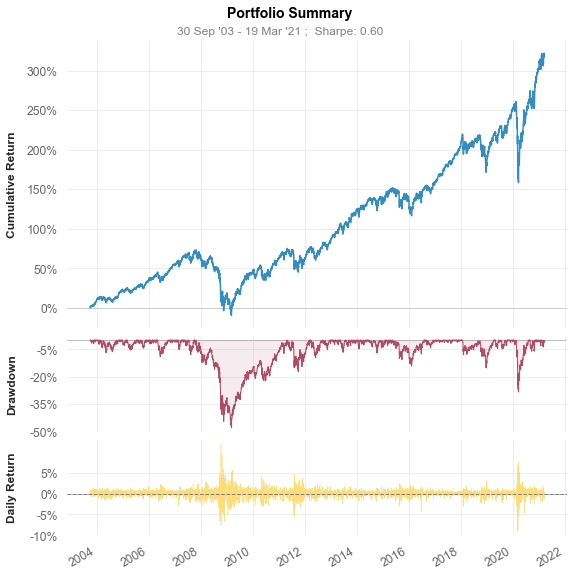

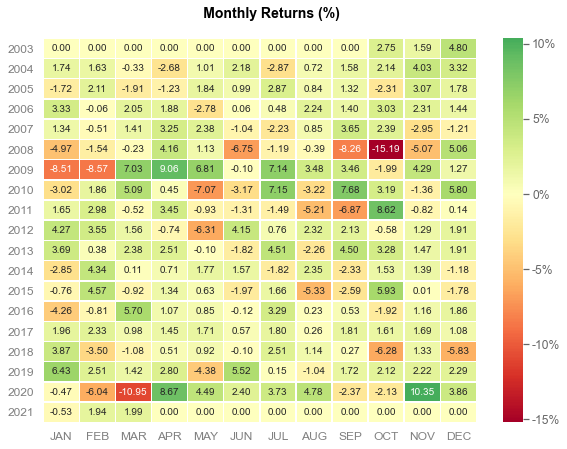

In [6]:
quantstats.reports.plots(df_return['ThreeFund_return'], mode='basic')

매일 비중을 맞춘 결과 연 복리 수익률 8.52%, 샤프 비율 0.6, MDD -48% 정도입니다. MDD가 너무 높아 그리 좋은 전략은 아닙니다.

In [7]:
quantstats.reports.metrics(df_return['ThreeFund_return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2003-10-01
End Period                 2021-03-19
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          317.39%
CAGR%                      8.52%
Sharpe                     0.6
Sortino                    0.84
Max Drawdown               -47.7%
Longest DD Days            1273
Volatility (ann.)          15.73%
Calmar                     0.18
Skew                       -0.12
Kurtosis                   16.22

Expected Daily %           0.03%
Expected Monthly %         0.68%
Expected Yearly %          7.81%
Kelly Criterion            6.28%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.59%
Expected Shortfall (cVaR)  -1.59%

Payoff Ratio               0.89
Profit Factor              1.13
Common Sense Ratio         1.05
CPC Index                  0.56
Tail Ratio                 0.94
Outlier Win Ratio          4.41
Outlier Loss Ratio         4

위에서 한 것처럼 그냥 만들어도 되지만, 백테스트에 많이 쓰이는 Backtrader 패키지를 한번 사용해 보겠습니다. Input 형식을 맞추어야 합니다.

In [8]:
vti = vti.rename({'vti_Close':'Close'}, axis='columns')
efa = efa.rename({'efa_Close':'Close'}, axis='columns')
agg = agg.rename({'agg_Close':'Close'}, axis='columns')

for column in ['Open', 'High', "Low"]:
    vti[column] = vti["Close"]
    efa[column] = efa["Close"]
    agg[column] = agg["Close"]

In [9]:
vti.head()

,Close,Open,High,Low
Date,,,,
2003-10-01,35.008533,35.008533,35.008533,35.008533
2003-10-02,35.166664,35.166664,35.166664,35.166664
2003-10-03,35.551212,35.551212,35.551212,35.551212
2003-10-06,35.705772,35.705772,35.705772,35.705772
2003-10-07,35.867489,35.867489,35.867489,35.867489


50:30:20 비율로 매수하고 20 거래일마다 리밸런싱하는 전략입니다.

In [12]:
class AssetAllocation_ThreeFund(bt.Strategy):
    params = (
        ('USequity',0.5),
        ('DEVequity', 0.3),
        ('USBond', 0.2),
    )
    def __init__(self):
        self.VTI = self.datas[0]
        self.EFA = self.datas[1]
        self.AGG = self.datas[2]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTI, target=self.params.USequity)
            self.order_target_percent(self.EFA, target=self.params.DEVequity)
            self.order_target_percent(self.AGG, target=self.params.USBond)
        self.counter += 1

In [13]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTI = bt.feeds.PandasData(dataname = vti)
EFA = bt.feeds.PandasData(dataname = efa)
AGG = bt.feeds.PandasData(dataname = agg)

cerebro.adddata(VTI)
cerebro.adddata(EFA)
cerebro.adddata(AGG)

cerebro.addstrategy(AssetAllocation_ThreeFund)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

#quantstats.reports.html(returns, output = 'Report_AssetAllocation_6040.html', title='AssetAllocation_6040')

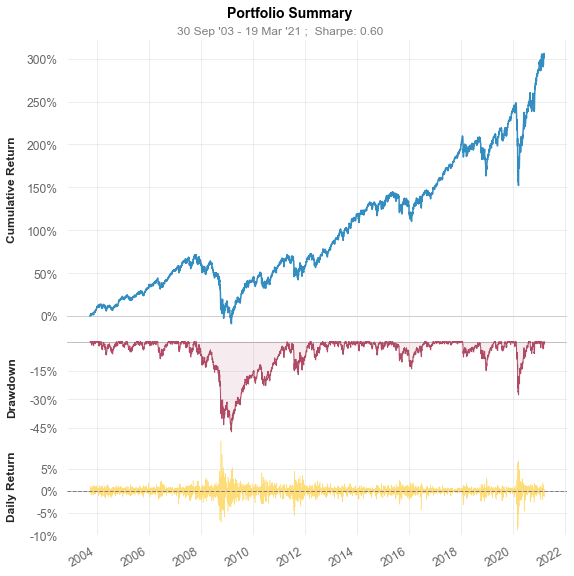

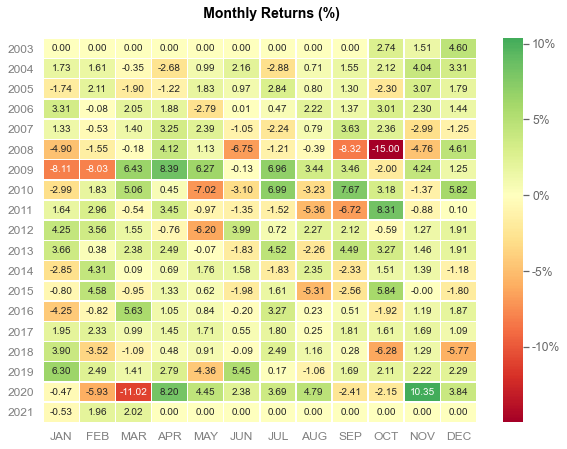

In [14]:
quantstats.reports.plots(returns, mode='basic')

20 거래일마다 리밸런싱하는 것으로 바꾸니 연 복리 수익률 8.28%, 샤프 비율 0.6, MDD -47% 정도로 나옵니다.

In [15]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2003-10-01
End Period                 2021-03-19
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          301.5%
CAGR%                      8.28%
Sharpe                     0.6
Sortino                    0.84
Max Drawdown               -46.84%
Longest DD Days            1278
Volatility (ann.)          15.18%
Calmar                     0.18
Skew                       -0.21
Kurtosis                   14.5

Expected Daily %           0.03%
Expected Monthly %         0.66%
Expected Yearly %          7.59%
Kelly Criterion            6.19%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.54%
Expected Shortfall (cVaR)  -1.54%

Payoff Ratio               0.89
Profit Factor              1.12
Common Sense Ratio         1.04
CPC Index                  0.56
Tail Ratio                 0.93
Outlier Win Ratio          4.29
Outlier Loss Ratio         4.

월간 데이터를 사용하면 훨씬 더 과거의 결과도 테스트해 볼 수 있습니다. 가장 긴 시계열의 경우 1900년 1월부터 2020년 12월까지의 데이터가 있습니다.

In [16]:
MonthlyReturn = pd.read_excel('MonthlyAssetClassReturn.xlsx')

In [17]:
MonthlyReturn.head()

,Data Index,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
0,1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


시계열로 바꾸어 주는 것이 사용하기 편합니다. 1열인 Data Index가 월말 날짜이므로, 이 열을 인덱스로 잡습니다.

In [18]:
MonthlyReturn = MonthlyReturn.set_index('Data Index')

In [19]:
MonthlyReturn.head()

,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,GSCI,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
Data Index,,,,,,,,,,,,,,,,,,,,,
1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


필요한 것만 뽑아옵니다. 미국 전체 채권 데이터가 없으니 10년 만기 국채로 대체합니다. 월간 미국 주식(S&P 500), 월간 선진국 주식, 월간 10년 만기 미국 국채 데이터입니다. 1970년 1월부터 2020년 12월까지 51년치 테스트입니다.

In [20]:
Monthly_ThreeFund = MonthlyReturn.loc[MonthlyReturn.index >= '1970-01-31', ['S&P 500 Total return', 'MSCI EAFE', 'US 10 YR']]
Monthly_ThreeFund.head()

,S&P 500 Total return,MSCI EAFE,US 10 YR
Data Index,,,
1970-01-31,-0.073601,-0.010800,0.015914
1970-02-28,0.055799,-0.022624,0.069766
1970-03-31,0.004407,0.016053,-0.007240
1970-04-30,-0.087527,-0.082823,-0.046007
1970-05-31,-0.057719,-0.049280,-0.002731


In [21]:
Monthly_ThreeFund['Monthly_ThreeFund'] = Monthly_ThreeFund['S&P 500 Total return'] * 0.5 + Monthly_ThreeFund['MSCI EAFE'] * 0.3 + Monthly_ThreeFund['US 10 YR'] * 0.2
Monthly_ThreeFund.head()

,S&P 500 Total return,MSCI EAFE,US 10 YR,Monthly_ThreeFund
Data Index,,,,
1970-01-31,-0.073601,-0.010800,0.015914,-0.036858
1970-02-28,0.055799,-0.022624,0.069766,0.035065
1970-03-31,0.004407,0.016053,-0.007240,0.005571
1970-04-30,-0.087527,-0.082823,-0.046007,-0.077812
1970-05-31,-0.057719,-0.049280,-0.002731,-0.044190


월간 데이터이므로, 일간 데이터 기준인 패키지가 주는 값을 적절히 조정해야 합니다. 1년 12개월 252거래일을 가정합니다. 1970년 1월부터 약 51년 동안 샤프 비율은 0.88로 나옵니다. 아래 그림의 제목 하단에 있는 샤프 비율은 무시하고, 직접 계산한 값을 보아야 합니다.

In [22]:
quantstats.stats.sharpe(Monthly_ThreeFund['Monthly_ThreeFund'])/math.sqrt(252/12)

0.8755044449937042

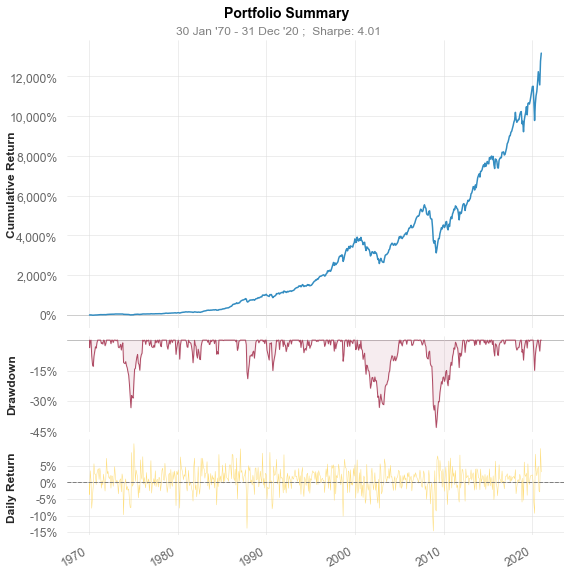

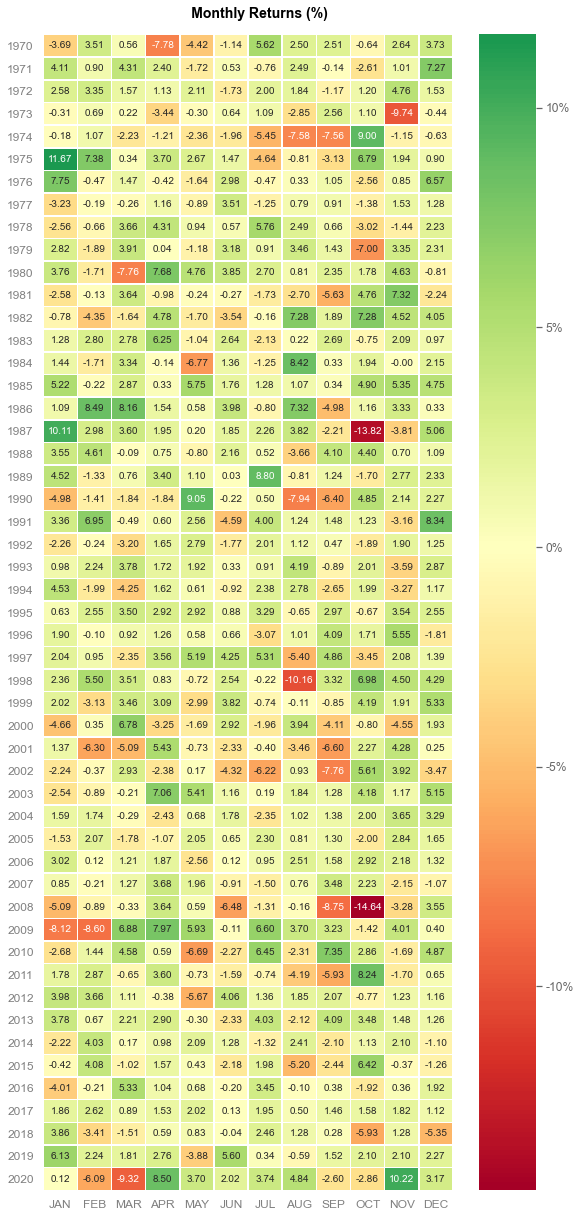

In [23]:
quantstats.reports.plots(Monthly_ThreeFund['Monthly_ThreeFund'], mode='basic')

연 복리 수익률 10.07%, 샤프 비율은 위에서 계산한대로 0.85, MDD는 -43%입니다. 대공황 시기가 아닌데도 40%대 MDD는 큽니다.

In [24]:
quantstats.reports.metrics(Monthly_ThreeFund['Monthly_ThreeFund'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               1970-01-31
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          13,175.09%
CAGR%                      10.07%
Sharpe                     4.01
Sortino                    6.39
Max Drawdown               -42.88%
Longest DD Days            1706
Volatility (ann.)          54.02%
Calmar                     0.23
Skew                       -0.48
Kurtosis                   1.62

Expected Daily %           0.8%
Expected Monthly %         0.8%
Expected Yearly %          10.06%
Kelly Criterion            31.08%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.74%
Expected Shortfall (cVaR)  -4.74%

Payoff Ratio               1.08
Profit Factor              1.94
Common Sense Ratio         2.43
CPC Index                  1.34
Tail Ratio                 1.25
Outlier Win Ratio          3.07
Outlier Loss Ratio     